# `snewpy.snowglobes` Usage Example

This notebook demonstrates how to use SNEWPY with SNOwGLoBES.

To start, make sure you have SNOwGLoBES installed and have downloaded one of the models that are part of SNEWPY. Adjust the directory paths in the following cell.

In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from snewpy import snowglobes

SNOwGLoBES_path = "/path/to/snowglobes/"  # where SNOwGLoBES is located
SNEWPY_models_base = "/path/to/snewpy/models/"  # directory containing SNEWPY models

Next, we will set up some basic parameters for the supernova we want to simulate.

In [2]:
# set distance in kpc
distance = 10

# set SNOwGLoBES detector to use
detector = "icecube"

# set SNEWPY model type and filename
modeltype = 'Zha_2021'
model = 's17'

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'

# Construct file system path of model file and name of output file
# The output file will be stored in the same directory as the model file.
modelfile = SNEWPY_models_base + "/" + modeltype + "/" + model + '.dat'
outfile = modeltype+"_"+model+"_"+transformation

# There are three ways to select a time range.
# Option 1 - don't specify tstart and tend, then the whole model is integrated
#tstart = None
#tend = None

# Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the window
#tstart = 0.7 * u.s
#tend = 0.8 * u.s

# Option 3 = specify sequence of time intervals, one fluence file is made for each interval
window_tstart = 0.742
window_tend = 0.762
window_bins = 60
tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) * u.s
tend = tstart + (window_tend - window_tstart) / window_bins * u.s
tmid = (tstart + tend) * 0.5

Now that everything’s set up, let’s start using SNOwGLoBES! Be patient—these three steps together may take a few minutes.

In [3]:
# snowglobes.generate_fluence integrates the model over the specified time window(s)
# and generates input files for SNOwGLoBES. It returns the full file path of the output file.
print("Preparing fluences ...")
tarredfile = snowglobes.generate_fluence(modelfile, modeltype, transformation, distance, outfile, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables = snowglobes.collate(SNOwGLoBES_path, tarredfile, skip_plots=True)

Preparing fluences ...
Running SNOwGLoBES ...
Calculations are 10.0% completed. ( 6  of  60 )
Calculations are 20.0% completed. ( 12  of  60 )
Calculations are 30.0% completed. ( 18  of  60 )
Calculations are 40.0% completed. ( 24  of  60 )
Calculations are 50.0% completed. ( 30  of  60 )
Calculations are 60.0% completed. ( 36  of  60 )
Calculations are 70.0% completed. ( 42  of  60 )
Calculations are 80.0% completed. ( 48  of  60 )
Calculations are 90.0% completed. ( 54  of  60 )
Calculations are 100.0% completed. ( 60  of  60 )
Collating results ...


Finally, since we chose option 3 above, and calculated the fluence in 60 time bins, we can now plot the event counts over time.

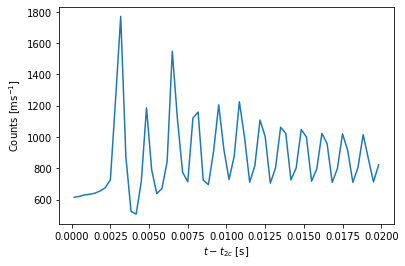

Total Events: 17459.043408289574


In [5]:
%matplotlib inline
nevents = np.zeros(len(tmid))
for i in range(len(tmid)):
    key = f"Collated_{outfile}_{i}_{detector}_events_smeared_weighted.dat"
    for j in range(1,len(tables[key]['header'].split())):
        nevents[i] += sum(tables[key]['data'][j])

# nevents is per bin, convert to per ms
factor = window_bins / (window_tend - window_tstart) / 1000

plt.plot(tmid - 0.742 * u.s, nevents * factor)
plt.xlabel("$t-t_{2c}$ [s]")
plt.ylabel("Counts [ms$^{-1}$]")
plt.show()
# compare to Figure 5 of Zha et al. (2021)
print("Total Events:", sum(nevents))